In [125]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DataLoader

In [126]:
!ls /kaggle/input/isbi2017

ls: cannot access '/kaggle/input/isbi2017': No such file or directory


In [127]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF

import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [128]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    
])

In [129]:
x_train = ('skin lesion/trainx')
y_train = ('skin lesion/trainy')
x_valid = ('skin lesion/validationx')
y_valid = ('skin lesion/validationy')
x_test = ('skin lesion/testx')
y_test = ('skin lesion/testy')

In [130]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms
        self.image_filenames = os.listdir(image_dir)

    def transforms(self,image,mask):
        #resizing
        resized_img = cv2.resize(image,(256,256), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, (256,256), interpolation=cv2.INTER_AREA)
        
        #Converting to tensors
        tensor_image = F.to_tensor(resized_img)
        tensor_mask = F.to_tensor(resized_mask)
        
        #Flipping
        if np.random.rand() > 0.5:
            tensor_image = F.hflip(tensor_image)
            ternsor_mask = F.hflip(tensor_mask)
        if np.random.rand() > 0.5:
            tensor_image = F.vflip(tensor_image)
            tensor_mask = F.vflip(tensor_mask)
            
        # Rotating
        if np.random.rand() > 0.5:
            tensor_image = F.rotate(tensor_image, angle=90)
            tensor_mask = F.rotate(tensor_mask, angle=90)
            
        #Cropping
        if np.random.rand() > 0.5:
            tensor_image = F.center_crop(tensor_image, (256,256))
            tensor_mask = F.center_crop(tensor_mask, (256,256))
        return tensor_image, tensor_mask
    
    
    def __getitem__(self, index):
        # Load image from file
        image_filename = self.image_filenames[index]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert('RGB')

        # Load mask from file
        mask_filename = image_filename.replace("imgx", "imgy")
        mask_path = os.path.join(self.mask_dir, mask_filename)
        mask = Image.open(mask_path).convert('L')

        
        return image, mask
        

    def __len__(self):
        return len(self.image_filenames)

In [131]:
def custom_collate(batch):
    images = []
    masks = []
    for sample in batch:
        image = transforms.ToTensor()(sample[0])
        mask = transforms.ToTensor()(sample[1])
        images.append(image)
        masks.append(mask)
    return torch.stack(images), torch.stack(masks)

In [132]:
train_data = MyDataset(x_train,y_train,transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=custom_collate)

validation_data=MyDataset(x_valid,y_valid,transform=transform)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True, collate_fn=custom_collate)

test_data=MyDataset(x_test,y_test,transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=custom_collate)

In [133]:
batch_size=32
num_batches_1 = len(validation_loader)
num_samples_1 = num_batches_1 * batch_size
num_batches_2 = len(test_loader)
num_samples_2 = num_batches_2 * batch_size

print("Number of samples in validation_loader:", num_samples_1)
print("Number of samples in test_loader:", num_samples_2)

Number of samples in validation_loader: 160
Number of samples in test_loader: 608


Data Visualisation

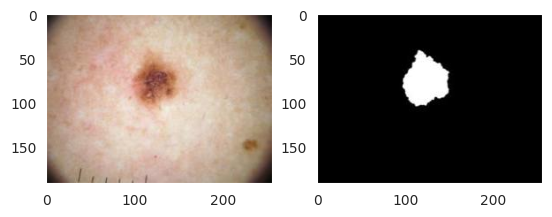

In [134]:
images, masks = next(iter(train_loader))

# Visualize the first image and its mask
image = images[0]
mask = masks[0]

# Convert image and mask to PIL format
image = TF.to_pil_image(image)
mask = TF.to_pil_image(mask)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the image and mask in the subplots
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')

# Show the plot
plt.show()

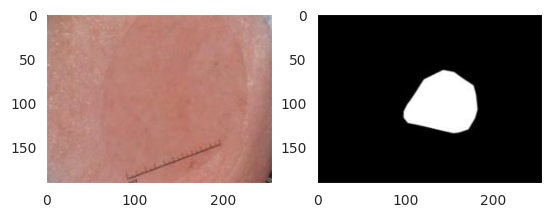

In [135]:
images, masks = next(iter(validation_loader))

# Visualize the first image and its mask
image = images[1]
mask = masks[1]

# Convert image and mask to PIL format
image = TF.to_pil_image(image)
mask = TF.to_pil_image(mask)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the image and mask in the subplots
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')

# Show the plot
plt.show()

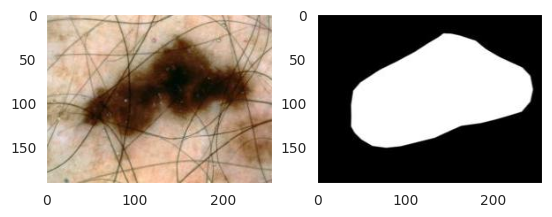

In [136]:
images, masks = next(iter(test_loader))

# Visualize the first image and its mask
image = images[1]
mask = masks[1]

# Convert image and mask to PIL format
image = TF.to_pil_image(image)
mask = TF.to_pil_image(mask)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the image and mask in the subplots
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')

# Show the plot
plt.show()

In [137]:
from tqdm import tqdm

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Model-1 : EOCNet 

In [139]:
import torch
import torch.nn as nn

class EOCNet(nn.Module):
    def __init__(self):
        super(EOCNet, self).__init__()
        # Define EOSC module
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, padding=0)
        # Define complementary boundary module
        self.bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)
    
    def forward(self, x):
        # Apply EOSC module
        x1 = nn.functional.relu(self.conv1(x))
        x2 = nn.functional.relu(self.conv2(x1))
        x3 = nn.functional.relu(self.conv3(x2))
        x4 = nn.functional.relu(self.conv4(x3))
        x_concat = torch.cat((x1, x2, x3, x4), dim=1)
        x5 = nn.functional.relu(self.conv5(x_concat))
        # Apply complementary boundary module
        x_bn = self.bn(x5)
        x6 = self.conv6(x_bn)
        # Apply sigmoid activation to get segmentation map
        y = torch.sigmoid(x6)
        return y


In [ ]:
import torchvision.models as models

class ImageSegmentationModule(nn.Module):
    def __init__(self):
        super(ImageSegmentationModule, self).__init__()
        # define ResNet-50 architecture as feature extractor
        self.resnet50 = models.resnet50(pretrained=True)
        # remove the last fully connected layer
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-1])
        
    def forward(self, x):
        # pass input x through ResNet-50 feature extractor
        feature_map = self.resnet50(x)
        return feature_map


In [ ]:
class OmniScaleModule(nn.Module):
    def __init__(self):
        super(OmniScaleModule, self).__init__()
        # define convolutional layers for 1x1 convolutions
        self.conv1x1a = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        self.conv1x1b = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        self.conv1x1c = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)

        # define convolutional layers for 3x3 convolutions
        self.conv3x3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=128)
        self.omni_scale_conv = nn.Conv2d(768, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # pass input x through 1x1 convolutional layers
        x_a = self.conv1x1a(x)
        x_b = self.conv1x1b(x)
        x_c = self.conv1x1c(x)

        # pass inputs through 3x3 convolutional layer
        x_c = self.conv3x3(x_c)

        # concatenate outputs of 1x1 and 3x3 convolutional layers
        x = torch.cat([x_a, x_b, x_c], dim=1)

        # pass concatenated features through Omni-Scale convolutional layer
        x = self.omni_scale_conv(x)

        return x


In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms


# Define hyperparameters

learning_rate = 0.001
num_epochs = 25



# Create the UNet model and move it to the device
model = EOCNet().to(device)

# Define the optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# define the loss function
criterion = nn.MSELoss()
# Train the model
Train_Loss_EOCNet=[]
Validation_Loss_EOCNet=[]
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    Train_Loss_EOCNet.append(epoch_loss)
    print(f'Train Epoch: {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}')

    # Evaluate the model on the validation data
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
    Validation_Loss_EOCNet.append(val_loss)
            
    print(f'Validation Loss: {val_loss / len(validation_loader):.4f}')
torch.save(model.state_dict(), 'EOCNet.pth')

Train Epoch: 1, Loss: 0.2270
Validation Loss: 0.2289
Train Epoch: 2, Loss: 0.2078
Validation Loss: 0.2311
Train Epoch: 3, Loss: 0.2013
Validation Loss: 0.2168
Train Epoch: 4, Loss: 0.1966
Validation Loss: 0.2324
Train Epoch: 5, Loss: 0.1921
Validation Loss: 0.2155
Train Epoch: 6, Loss: 0.1886
Validation Loss: 0.2334
Train Epoch: 7, Loss: 0.1853
Validation Loss: 0.2166
Train Epoch: 8, Loss: 0.1823
Validation Loss: 0.2109
Train Epoch: 9, Loss: 0.1794
Validation Loss: 0.2108
Train Epoch: 10, Loss: 0.1773
Validation Loss: 0.2111
Train Epoch: 11, Loss: 0.1748
Validation Loss: 0.2034
Train Epoch: 12, Loss: 0.1729
Validation Loss: 0.2039
Train Epoch: 13, Loss: 0.1709
Validation Loss: 0.2078
Train Epoch: 14, Loss: 0.1686
Validation Loss: 0.2032
Train Epoch: 15, Loss: 0.1664
Validation Loss: 0.1965
Train Epoch: 16, Loss: 0.1644
Validation Loss: 0.1897
Train Epoch: 17, Loss: 0.1629
Validation Loss: 0.1973
Train Epoch: 18, Loss: 0.1609
Validation Loss: 0.1899
Train Epoch: 19, Loss: 0.1589
Validat

[14.300185322761536, 13.090302526950836, 12.683320164680481, 12.385125830769539, 12.10352647304535, 11.880501613020897, 11.672033250331879, 11.48446974158287, 11.305281475186348, 11.16946142911911, 11.013880297541618, 10.894403591752052, 10.764866188168526, 10.6236841827631, 10.484977170825005, 10.356629505753517, 10.26401261985302, 10.13572496175766, 10.009347349405289, 9.915268957614899, 9.822543188929558, 9.696351557970047, 9.58023089170456, 9.490651033818722, 9.42554558813572]
[1.1442948281764984, 1.1553001254796982, 1.0839141756296158, 1.1620562970638275, 1.0775145292282104, 1.1668930500745773, 1.0830978006124496, 1.0543766766786575, 1.0541798025369644, 1.0553997606039047, 1.016930028796196, 1.0196920782327652, 1.0389622896909714, 1.0158592015504837, 0.9826407879590988, 0.9487060606479645, 0.9864972531795502, 0.9494040459394455, 0.9445171654224396, 0.9394140243530273, 0.8981964737176895, 0.8960489928722382, 0.8266510963439941, 0.9126123338937759, 0.8563429564237595]


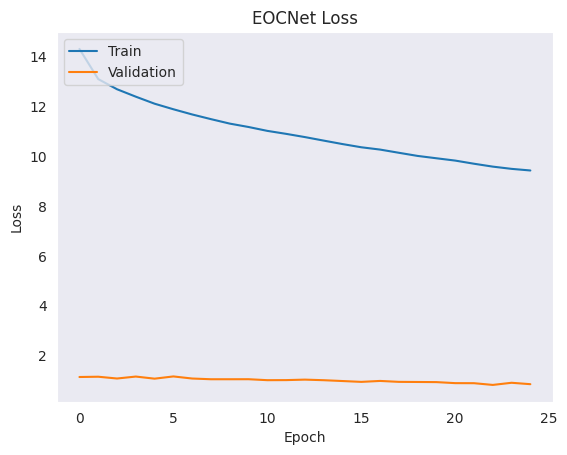

In [141]:
print(Train_Loss_EOCNet)
print(Validation_Loss_EOCNet)

import seaborn as sns
sns.set_style("darkgrid")
plt.plot(Train_Loss_EOCNet)
plt.plot(Validation_Loss_EOCNet)
plt.title('EOCNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



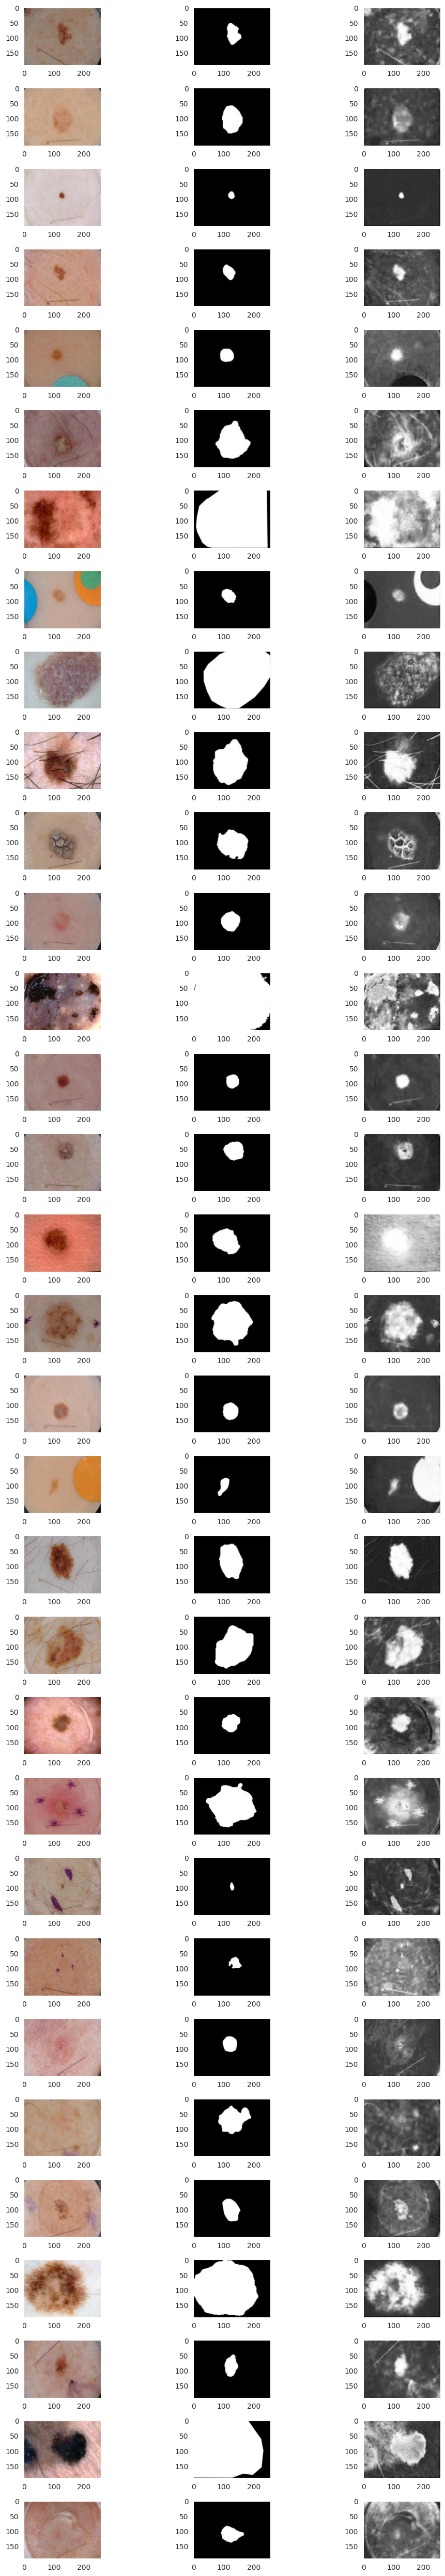

In [142]:
# plot predicted outputs for the validation data and compare them with the ground-truth masks
# no gridlines
plt.rcParams["grid.linewidth"] = 0
model.eval()
with torch.no_grad():
    for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        break

# plot the predicted output batch and ground-truth batch use make_grid
fig, axs = plt.subplots(32, 3, figsize=(10, 50))
# tight_layout
fig.tight_layout()
for i in range(32):
    axs[i, 0].imshow(TF.to_pil_image(data[i].cpu()))
    axs[i, 1].imshow(TF.to_pil_image(target[i].cpu()), cmap='gray')
    axs[i, 2].imshow(TF.to_pil_image(output[i].cpu()), cmap='gray')
plt.show()






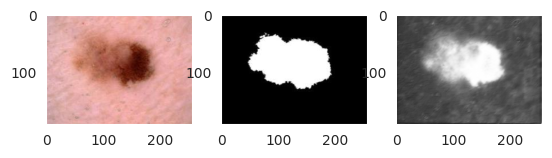

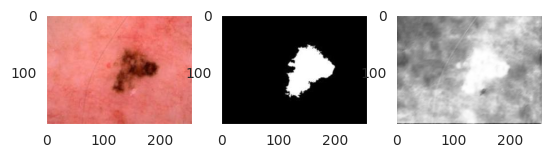

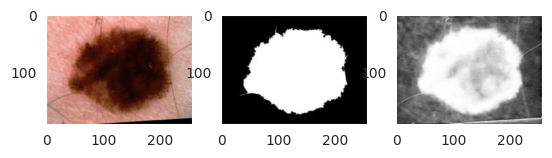

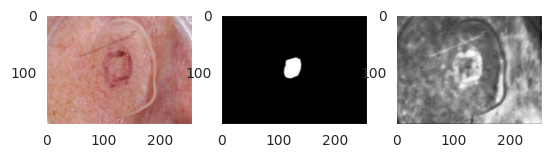

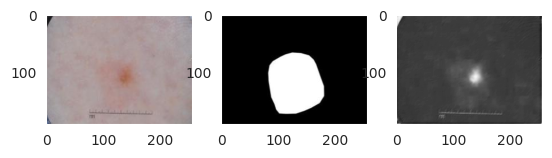

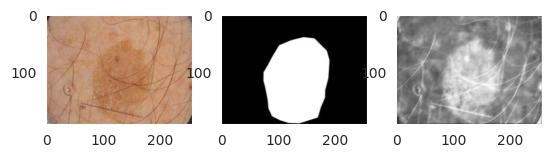

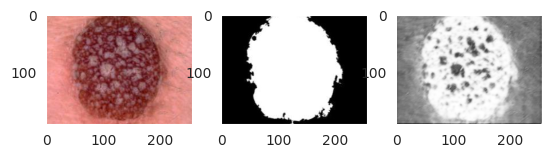

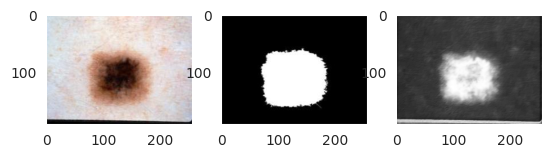

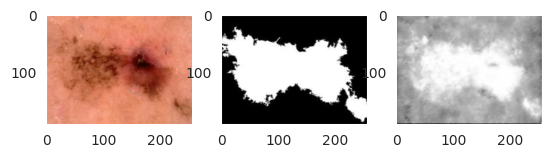

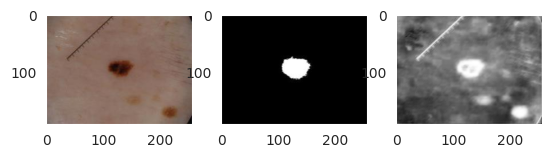

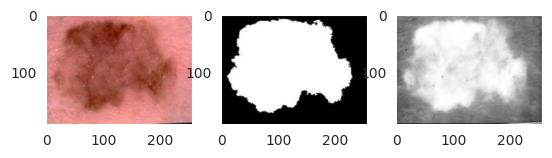

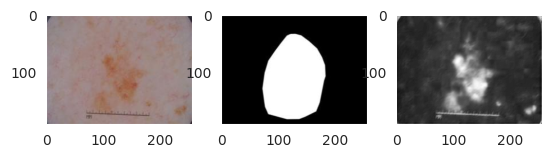

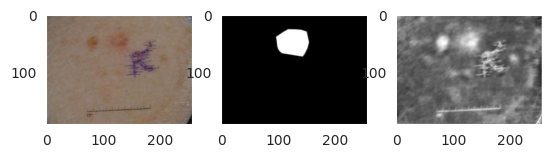

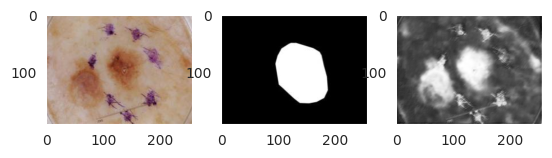

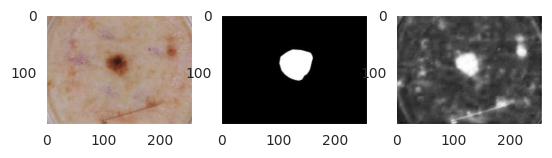

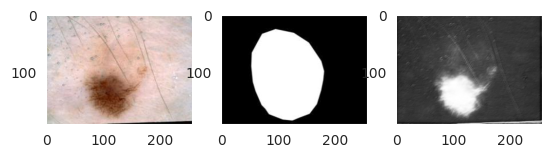

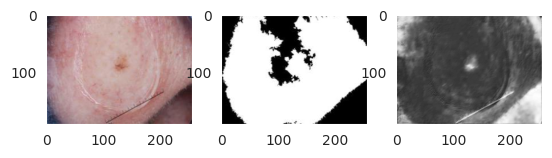

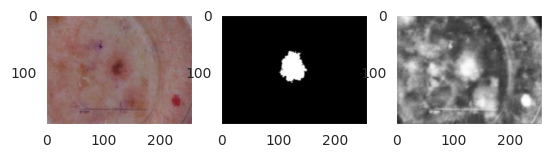

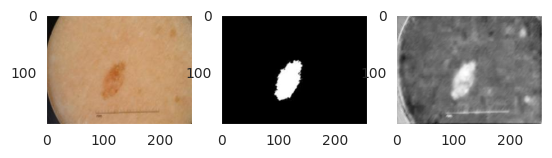

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# set the model to evaluation mode
model = model.eval()

# evaluate the model on the test data
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs

        # visualize the predictions
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(),cmap='gray')
#         print(outputs[0].permute(1,2,0).cpu().numpy().shape)
        plt.show()


In [144]:
#Load the saved model
model = EOCNet().to(device)
model.load_state_dict(torch.load('EOCNet.pth'))
# model.eval()


<All keys matched successfully>

In [145]:
import torch

def calculate_metrics(output, target):
    with torch.no_grad():
        output = output.squeeze().round()
        target = target.squeeze()
        TP = ((output == 1) & (target == 1)).sum().float()
        TN = ((output == 0) & (target == 0)).sum().float()
        FP = ((output == 1) & (target == 0)).sum().float()
        FN = ((output == 0) & (target == 1)).sum().float()
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        dice_coefficient = (2 * TP) / (2 * TP + FP + FN)
        jaccard_similarity = TP / (TP + FP + FN)
        
        return accuracy.item(), sensitivity.item(), specificity.item(), dice_coefficient.item(), jaccard_similarity.item()


In [146]:
for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        break
metric_1=calculate_metrics(output, target)

print("Accuracy: ",metric_1[0])
print("Sensitivity: ",metric_1[1])
print("Specificity: ",metric_1[2])
print("Dice Coefficient: ",metric_1[3])
print("Jaccard Similarity: ",metric_1[4])


Accuracy:  0.7889013886451721
Sensitivity:  0.6196677684783936
Specificity:  0.8332734107971191
Dice Coefficient:  0.5494586825370789
Jaccard Similarity:  0.3787955939769745


Model-2: UNet 

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1))


In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms


# Define hyperparameters

learning_rate = 0.001
num_epochs = 25



# Create the UNet model and move it to the device
model_2= UNet(n_channels=3, n_classes=1).to(device)

# Define the optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
# Train the model
Train_Loss_UNet=[]
Validation_Loss_UNet=[]
for epoch in range(num_epochs):
    epoch_loss = 0
    model_2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_2(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    Train_Loss_UNet.append(epoch_loss)
    print(f'Train Epoch: {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}')

    # Evaluate the model on the validation data
    model_2.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model_2(data)
            val_loss += criterion(output, target).item()
    Validation_Loss_UNet.append(val_loss)
    print(f'Validation Loss: {val_loss / len(validation_loader):.4f}')


Train Epoch: 1, Loss: 0.6455
Validation Loss: 0.6526
Train Epoch: 2, Loss: 0.6452
Validation Loss: 0.6554
Train Epoch: 3, Loss: 0.6451
Validation Loss: 0.6568
Train Epoch: 4, Loss: 0.6449
Validation Loss: 0.6560
Train Epoch: 5, Loss: 0.6456
Validation Loss: 0.6538
Train Epoch: 6, Loss: 0.6457
Validation Loss: 0.6543
Train Epoch: 7, Loss: 0.6455
Validation Loss: 0.6555
Train Epoch: 8, Loss: 0.6457
Validation Loss: 0.6535
Train Epoch: 9, Loss: 0.6455
Validation Loss: 0.6550
Train Epoch: 10, Loss: 0.6453
Validation Loss: 0.6529
Train Epoch: 11, Loss: 0.6458
Validation Loss: 0.6554
Train Epoch: 12, Loss: 0.6450
Validation Loss: 0.6521
Train Epoch: 13, Loss: 0.6449
Validation Loss: 0.6541
Train Epoch: 14, Loss: 0.6450
Validation Loss: 0.6536
Train Epoch: 15, Loss: 0.6454
Validation Loss: 0.6534
Train Epoch: 16, Loss: 0.6453
Validation Loss: 0.6531
Train Epoch: 17, Loss: 0.6451
Validation Loss: 0.6532
Train Epoch: 18, Loss: 0.6453
Validation Loss: 0.6579
Train Epoch: 19, Loss: 0.6452
Validat

[40.66784530878067, 40.64772093296051, 40.63862007856369, 40.629244923591614, 40.669980585575104, 40.678850054740906, 40.6663613319397, 40.681435346603394, 40.66626560688019, 40.65647250413895, 40.683888614177704, 40.634895622730255, 40.626205265522, 40.63330316543579, 40.66017484664917, 40.6507568359375, 40.642471611499786, 40.654858350753784, 40.64976078271866, 40.67078626155853, 40.662913143634796, 40.64950239658356, 40.65768313407898, 40.65153044462204, 40.662290036678314]
[3.2631776332855225, 3.276939034461975, 3.284056067466736, 3.2802361249923706, 3.2690359950065613, 3.2715801000595093, 3.277545154094696, 3.2675456404685974, 3.275247633457184, 3.2644715905189514, 3.2769603729248047, 3.2607314586639404, 3.2704319953918457, 3.2681742310523987, 3.2670633792877197, 3.2656164169311523, 3.26581072807312, 3.2892739176750183, 3.2689066529273987, 3.258877694606781, 3.2743042707443237, 3.2700753808021545, 3.27959281206131, 3.263142943382263, 3.2636019587516785]


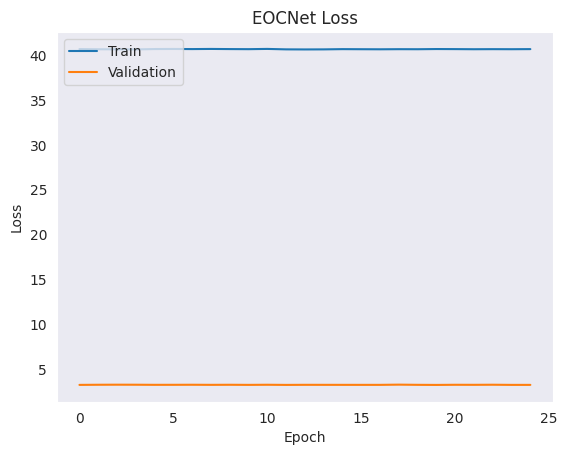

In [149]:
print(Train_Loss_UNet)
print(Validation_Loss_UNet)

import seaborn as sns
sns.set_style("darkgrid")
plt.plot(Train_Loss_UNet)
plt.plot(Validation_Loss_UNet)
plt.title('EOCNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


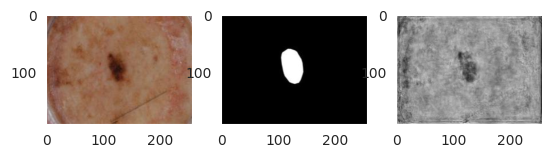

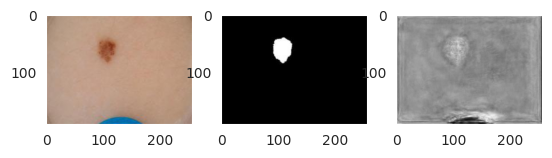

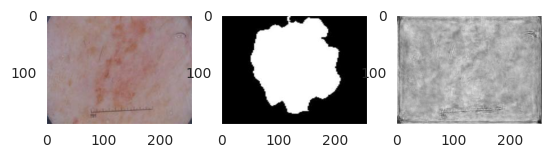

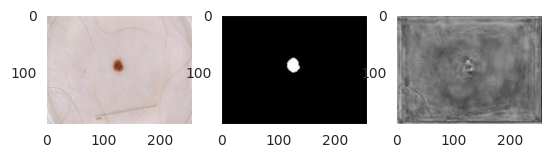

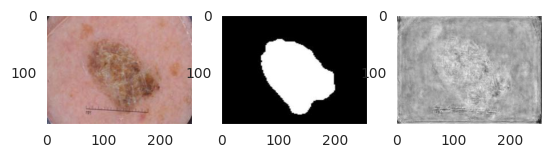

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# set the model to evaluation mode
model_2= model_2.eval()

# evaluate the model on the test data
with torch.no_grad():
    for i, (inputs, labels) in enumerate(validation_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_2(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs

        # visualize the predictions
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
#         print(outputs[0].permute(1,2,0).cpu().numpy().shape)
        plt.show()

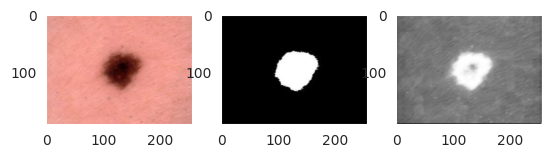

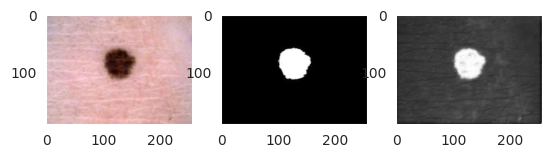

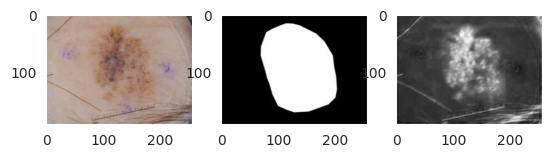

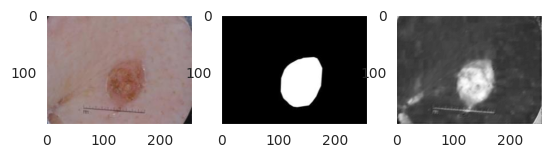

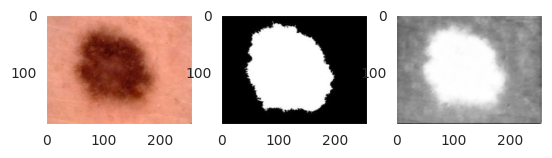

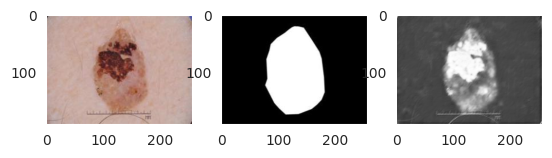

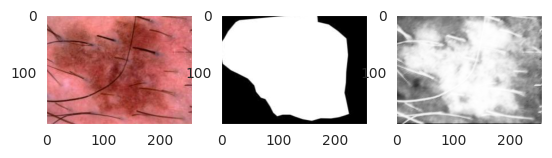

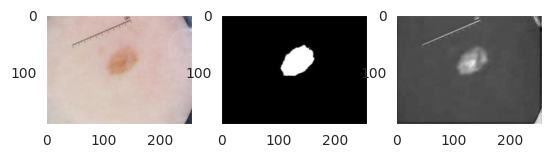

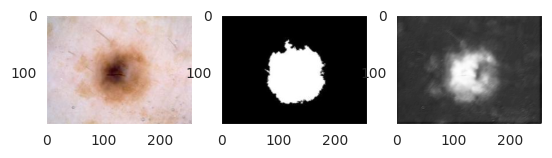

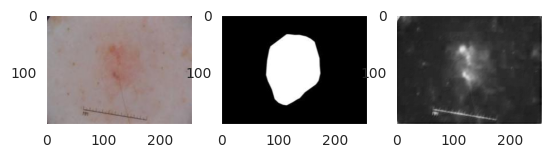

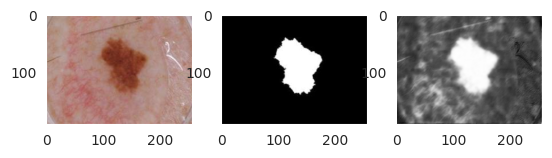

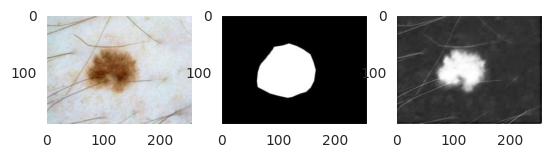

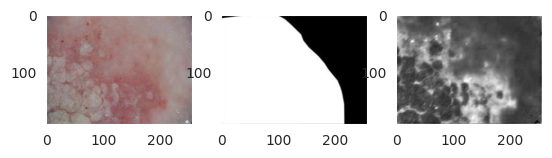

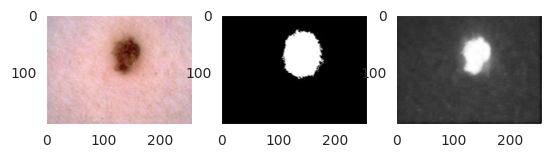

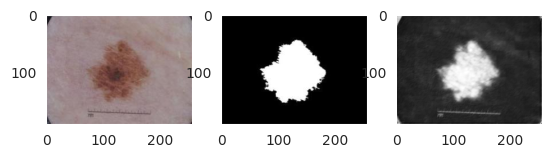

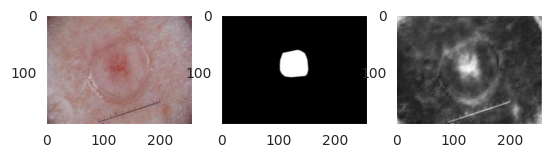

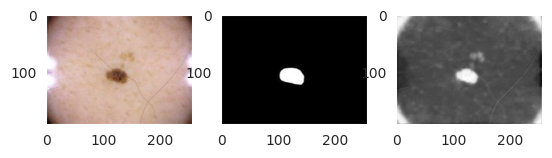

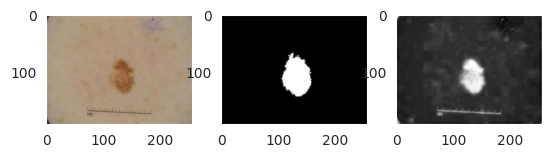

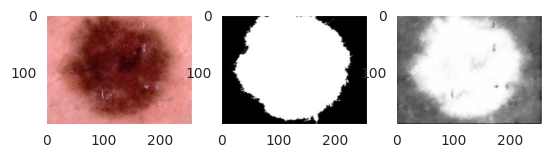

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# set the model to evaluation mode
model_2 = model.eval()

# evaluate the model on the test data
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_2(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs

        # visualize the predictions
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
#         print(outputs[0].permute(1,2,0).cpu().numpy().shape)
        plt.show()

In [152]:
import torch


def calculate_metrics(output, target):
    with torch.no_grad():
        output = output.squeeze().round()
        target = target.squeeze()
        TP = ((output == 1) & (target == 1)).sum().float()
        TN = ((output == 0) & (target == 0)).sum().float()
        FP = ((output == 1) & (target == 0)).sum().float()
        FN = ((output == 0) & (target == 1)).sum().float()
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        dice_coefficient = (2 * TP) / (2 * TP + FP + FN)
        jaccard_similarity = TP / (TP + FP + FN)
        
        return accuracy.item(), sensitivity.item(), specificity.item(), dice_coefficient.item(), jaccard_similarity.item()


In [153]:
for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_2(data)
        break
metrics=calculate_metrics(output, target)


print("Accuracy : ",metrics[0])
print("Sensitivity : ",metrics[1])
print("Specificity : ",metrics[2])
print("Dice Coefficient : ",metrics[3])
print("Jaccard Similarity : ",metrics[4])


Accuracy :  0.7253170609474182
Sensitivity :  0.6750089526176453
Specificity :  0.7445175051689148
Dice Coefficient :  0.5758450627326965
Jaccard Similarity :  0.40434157848358154
